In [1]:
from pathlib import Path
import dill
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# parent directory to path to import src module
sys.path.insert(0, str(Path.cwd().parent))

import src.unimib_snowit_project.utils as u

Loading the data

In [3]:
DATA_PKL_DIR = 'data_loaded'

USERS_PKL_FILENAME = 'users.pkl'
PROFILES_PKL_FILENAME = 'profiles.pkl'
CARDS_PKL_FILENAME = 'cards.pkl'
ORDERS_PKL_FILENAME = 'orders.pkl'
ORDER_DETAILS_PKL_FILENAME = 'order_details.pkl'

root_dir_path = u.get_root_dir() 

data_pkl_dir_path = root_dir_path / DATA_PKL_DIR
users_pkl_path = data_pkl_dir_path / USERS_PKL_FILENAME
profiles_pkl_path = data_pkl_dir_path / PROFILES_PKL_FILENAME
cards_pkl_path = data_pkl_dir_path / CARDS_PKL_FILENAME
orders_pkl_path = data_pkl_dir_path / ORDERS_PKL_FILENAME
order_details_pkl_path = data_pkl_dir_path / ORDER_DETAILS_PKL_FILENAME

def load_pkl(pkl_path):
    with pkl_path.open('rb') as fh:
        return dill.load(fh)

users_df = load_pkl(users_pkl_path)
profiles_df = load_pkl(profiles_pkl_path)
cards_df = load_pkl(cards_pkl_path)
orders_df = load_pkl(orders_pkl_path)
order_details_df = load_pkl(order_details_pkl_path)


Building order_kpi from cleaned PKL data

In [4]:
print("--- Building order_kpi from cleaned PKL data ---")

# 1. Keep only fulfilled items for revenue
order_details_clean = order_details_df[order_details_df["item.status"] == "fulfilled"].copy()

# 2. Parse dates in orders
orders_df["createdAt"] = pd.to_datetime(orders_df["createdAt"])

# 3. Join order_details → orders (to bring user + metadata onto each item)
od_orders = order_details_clean.merge(
    orders_df[["order.uid", "user.uid", "createdAt", "source", "tenant"]],
    on="order.uid",
    how="left"
)

# 4. Basic revenue at item level
od_orders["item_revenue"] = od_orders["item.amount"].astype(float)

# 5. Aggregate to order level (one row per order)
order_kpi = (
    od_orders
    .groupby("order.uid", as_index=False)
    .agg(
        user_uid=("user.uid", "first"),
        order_date=("createdAt", "first"),
        source=("source", "first"),
        tenant=("tenant", "first"),
        order_revenue=("item_revenue", "sum")
    )
)

order_kpi.head()


--- Building order_kpi from cleaned PKL data ---


,order.uid,user_uid,order_date,source,tenant,order_revenue
0,0013wz6tllybz6dczg,z3t5ctevz3qpnnetsbusgbc5qu,2023-12-09,app,snowit,32.0
1,001ar3c4lxvfkbzd3h,ecgsdgxexzoysahonss2wx4pmi,2024-02-03,website,snowit,168.0
2,001lwhyxkqfaisi7ll,woypybkscvrplitnuwpzrl3knd,2023-02-08,website,snowit_esterno,627.2
3,001mdurceg4exzah8t,jixtqm2shcppjcqxdqolsdph5p,2025-02-07,website,snowit_esterno,34.0
4,001pf8tqssr6hpviox,jf7kdg4zskzkmv1nu4vya2sbdd,2024-01-01,website,snowit_esterno,53.0


RFM MODEL – Deterministic Segmentation

compute R (Recency), F (Frequency), M (Monetary) per customer using order_kpi.

Compute R, F, M (Building RFM table from order_kpi)

In [5]:
print("--- Building RFM table from order_kpi ---")

# Reference date for recency (end of observation window)
snapshot_date = order_kpi["order_date"].max() + pd.Timedelta(days=1)

rfm = (
    order_kpi
    .groupby("user_uid")
    .agg(
        last_order_date=("order_date", "max"),      # most recent purchase
        frequency=("order.uid", "nunique"),         # number of orders
        monetary=("order_revenue", "sum")           # total spending
    )
    .reset_index()
)

# Recency in days
rfm["recency"] = (snapshot_date - rfm["last_order_date"]).dt.days

rfm.head()


--- Building RFM table from order_kpi ---


,user_uid,last_order_date,frequency,monetary,recency
0,001vktlc5zbkx2bazqkwmrpru9,2025-01-01,2,177.15,46
1,002cjigqy3zbbtaehc5a7f0iod,2023-02-11,1,150.00,736
2,005bg1dx4mxrhsdjqmpwxr4rni,2024-03-28,1,101.00,325
3,005dpt4a0puxgicccu6ixvlc9f,2025-01-01,2,43.00,46
4,00a3sq7bg9xnyotnmsqkmyjhgt,2023-02-08,2,60.00,739


RFM scores (quantile-based 1–5)

In [6]:
def rfm_score(series, reverse=False):
    # 5 = best, 1 = worst
    quantiles = series.quantile([0.2, 0.4, 0.6, 0.8]).to_dict()
    
    def score(x):
        if reverse:  # for recency (lower is better → higher score)
            if x <= quantiles[0.2]: return 5
            elif x <= quantiles[0.4]: return 4
            elif x <= quantiles[0.6]: return 3
            elif x <= quantiles[0.8]: return 2
            else: return 1
        else:
            if x <= quantiles[0.2]: return 1
            elif x <= quantiles[0.4]: return 2
            elif x <= quantiles[0.6]: return 3
            elif x <= quantiles[0.8]: return 4
            else: return 5
    
    return series.apply(score)

rfm["R_score"] = rfm_score(rfm["recency"], reverse=True)
rfm["F_score"] = rfm_score(rfm["frequency"], reverse=False)
rfm["M_score"] = rfm_score(rfm["monetary"], reverse=False)

rfm["RFM_score"] = rfm["R_score"].astype(str) + rfm["F_score"].astype(str) + rfm["M_score"].astype(str)
rfm.head()


,user_uid,last_order_date,frequency,monetary,recency,R_score,F_score,M_score,RFM_score
0,001vktlc5zbkx2bazqkwmrpru9,2025-01-01,2,177.15,46,4,3,4,434
1,002cjigqy3zbbtaehc5a7f0iod,2023-02-11,1,150.00,736,1,1,3,113
2,005bg1dx4mxrhsdjqmpwxr4rni,2024-03-28,1,101.00,325,3,1,3,313
3,005dpt4a0puxgicccu6ixvlc9f,2025-01-01,2,43.00,46,4,3,1,431
4,00a3sq7bg9xnyotnmsqkmyjhgt,2023-02-08,2,60.00,739,1,3,2,132


Define customer segments

In [7]:
def segment_from_rfm(row):
    r, f, m = row["R_score"], row["F_score"], row["M_score"]
    if r >= 4 and f >= 4 and m >= 4:
        return "Champions"
    if r >= 3 and f >= 3:
        return "Loyal"
    if r >= 4 and f <= 2:
        return "New Customers"
    if r <= 2 and f >= 3:
        return "At Risk"
    if r <= 2 and f <= 2 and m <= 2:
        return "Lost"
    return "Others"

rfm["segment"] = rfm.apply(segment_from_rfm, axis=1)
rfm["segment"].value_counts()


segment
Others           35205
New Customers    26636
Loyal            24878
Lost             24341
Champions        19687
At Risk          17375
Name: count, dtype: int64

Visualizing Customer Distribution

C:\Users\Admin\AppData\Local\Temp\ipykernel_10564\1480255284.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


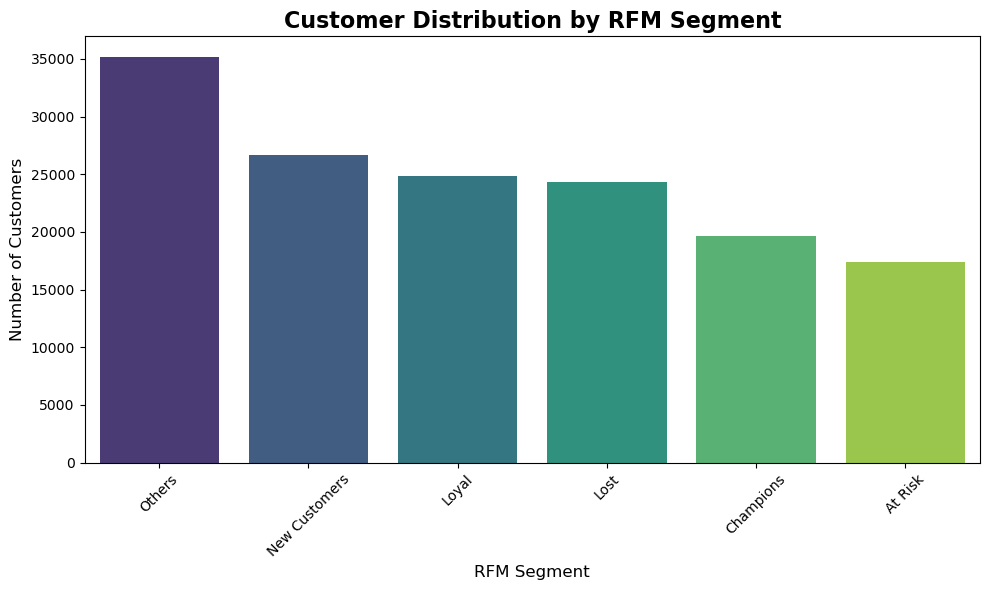

In [9]:
# --- Visualization ---
plt.figure(figsize=(10, 6))
sns.barplot(
    x=segment_counts.index,
    y=segment_counts.values,
    palette="viridis"
)
plt.title("Customer Distribution by RFM Segment", fontsize=16, weight="bold")
plt.xlabel("RFM Segment", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()